# Proyek Analisis Data: Brazilian E-Commerce Public Dataset by Olist

- **Nama:** Umar Sani
- **Email:** umarsani@student.uns.ac.id
- **ID Dicoding:** umarsani16

## Menentukan Pertanyaan Bisnis

1. Bagaimana perkembangan transaksi e-commerce di Brazil dari tahun 2016 hingga 2018?

2. Pada hari apa dalam seminggu puncak aktivitas pelanggan melakukan pembelian?

3. Pada rentang waktu apa pelanggan biasanya melakukan pembelian? (Pagi, Siang, Sore, atau Malam)

4. Kota mana saja yang memiliki aktivitas pembelian tertinggi?

5. Bagaimana persebaran geografis aktivitas pembelian di seluruh wilayah Brazil?


## Import Semua Packages/Library yang Digunakan

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
import json
import requests
import folium
from folium.plugins import FastMarkerCluster
import zipfile
import os, shutil
from PIL import Image

## Helper function

In [26]:
# sns.countplot dengan format yang telah disesuaikan

def countplot_format(df, x, ax, title, xlabel, ylabel, hue, y=None, order=None, custom_label=None, rotate_label=False, padding_label=-0.1, palette='flare', legend=False):

    if order:
        sns.countplot(x=x, y=y, data=df, ax=ax, hue=hue, order=order, palette=palette, legend=legend)
    else:
        sns.countplot(x=x, y=y, data=df, ax=ax, hue=hue, palette=palette, legend=False)

    ax.set_title(title, pad=24)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_label_coords(0.5, padding_label)

    if custom_label:
        ax.set_xticklabels(custom_label)

    if rotate_label:
        ax.tick_params(axis='x', labelrotation=45)

    if legend:
        ax.legend(loc='upper left')

    ncount = len(df)

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')


## Data Wrangling

### Gathering Data

Mengunduh dataset menggunakan API Kaggle, mengekstrak file, dan membaca file CSV-nya.


In [27]:
# Unduh dataset dari Kaggle

! ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d olistbr/brazilian-ecommerce

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
def extract(source, destination):
    zip = zipfile.ZipFile(source, "r")
    zip.extractall(destination)
    zip.close()
    print("[SUCCESS] {} berhasil diekstrak ke '{}'".format(os.path.basename(source), destination))

source = "/content/brazilian-ecommerce.zip"
destination = "/content/brazilian-ecommerce"

extract(source, destination)

[SUCCESS] brazilian-ecommerce.zip berhasil diekstrak ke '/content/brazilian-ecommerce'


In [29]:
path = '/content/brazilian-ecommerce'

customer = pd.read_csv(path + '/olist_customers_dataset.csv')
geolocation = pd.read_csv(path + '/olist_geolocation_dataset.csv')
order_items = pd.read_csv(path + '/olist_order_items_dataset.csv')
order_payments = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders = pd.read_csv(path + '/olist_orders_dataset.csv')

### Assessing Data

Memahami struktur dataset

In [30]:
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [31]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [32]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [33]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [34]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [35]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [36]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [37]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [38]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [39]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### Cleaning Data

Pada dataframe `orders`, beberapa kolom tanggal masih bertipe data `object`, sehingga perlu diubah menjadi tipe data `datetime` agar lebih mudah dieksplorasi berdasarkan waktunya.

In [40]:
# Mengubah tipe data kolom-kolom tanggal ada dataframe orders
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    orders[col] = pd.to_datetime(orders[col])

# Mengekstrak nilai tanggal, bulan, dan tahun dari dataframe orders
orders['order_purchase_year'] = orders['order_purchase_timestamp'].apply(lambda x: x.year)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.month)
orders['order_purchase_month_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders['order_purchase_year_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
orders['order_purchase_date'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Mengekstrak nilai tanggal, hari dalam mingguan, dan nama hari dalam minggu
orders['order_purchase_day'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Mengekstrak nilai jam dan rentang waktu
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 5, 10, 15, 18, 23]
hours_labels = ['Malam', 'Pagi', 'Siang', 'Sore', 'Malam']
orders['order_purchase_time_day'] = pd.cut(orders['order_purchase_hour'], hours_bins, labels=hours_labels, ordered=False)

# Dataframe baru setelah transformasi
orders.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,2017-10,20171002,2,0,Mon,10,Pagi
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,2018-07,20180724,24,1,Tue,20,Malam
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,2018-08,20180808,8,2,Wed,8,Pagi
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,2017-11,20171118,18,5,Sat,19,Malam
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,2018-02,20180213,13,1,Tue,21,Malam
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017,7,Jul,2017-07,20170709,9,6,Sun,21,Malam
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaN,2017-05-09,2017,4,Apr,2017-04,20170411,11,1,Tue,12,Siang
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017,5,May,2017-05,20170516,16,1,Tue,13,Siang
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,2017,1,Jan,2017-01,20170123,23,0,Mon,18,Sore
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,2017,7,Jul,2017-07,20170729,29,5,Sat,11,Siang


Dibawah merupakan `orders` yang telah diformat, kolom-kolom tanggal telah diubah menjadi time data `datetime`. Selain itu, beberapa kolom-kolom baru dibuat untuk mewakili setiap satuan tanggal dan waktu.

In [41]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_year            99441 non-null  int64         
 9   order_purchase_month           99441 non-null  int64         
 10  order_purchase_month_name      99441 non-null  object        
 11  order_purchase_

Berikutnya, lakukan pencocokan zip code dengan setiap nama region di Brazil.

In [42]:
# Menggabungkan orders dengan order_items
orders_items = orders.merge(order_items, how='left', on='order_id')
orders_items = orders_items.merge(customer, how='left', on='customer_id')

# Menggunakan API untuk mendapatkan nama kota di Brazil
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
brazil_cities = pd.DataFrame(content)
brazil_cities['nome_regiao'] = brazil_cities['regiao'].apply(lambda x: x['nome'])
brazil_cities.drop('regiao', axis=1, inplace=True)
brazil_cities.drop_duplicates(inplace=True)

Menghilangkan outlier, berdasarkan batas-batas koordinat Brazil.

In [43]:
# Batas paling utara Brazil adalah 5 derajat 16′ 27.8″ N latitude;
geo_clean = geolocation[geolocation.geolocation_lat <= 5.27438888]

# Batas paling barat Brazil adalah 73 derajat, 58′ 58.19″W longitude
geo_clean = geo_clean[geo_clean.geolocation_lng >= -73.98283055]

# Batas paling selatan Brazil adalah 33 derajat, 45′ 04.21″ S Latitude.
geo_clean = geo_clean[geo_clean.geolocation_lat >= -33.75116944]

# Batas paling timur Brazil adalah 34 derajat, 47′ 35.33″ W Long.
geo_clean = geo_clean[geo_clean.geolocation_lng <=  -34.79314722]

# Grup geolocation dengan zip code
geo_group = geo_clean.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Menggabungkan dengan orders_items
orders_items = orders_items.merge(brazil_cities, how='left', left_on='customer_state', right_on='sigla')
orders_items = orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix',
                                        right_on='geolocation_zip_code_prefix')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,...,customer_state,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,...,SP,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,...,BA,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,...,GO,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,...,RN,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,...,SP,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


## Exploratory Data Analysis (EDA)

### Eksplorasi dataframe Customer

Pertama, mari kita lihat kembali bagaimana struktur dataframe `customer`.

In [44]:
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Dataframe `customer` memiliki kolom `customer_city` dan `customer_state`. Hal tersebut dapat kita gunakan untuk mengetahui di kota mana yang paling banyak memiliki pembeli.

In [65]:
customer.groupby('customer_city')[['customer_id']].count().sort_values(by='customer_id', ascending=False).reset_index().head()

,customer_city,customer_id
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521


In [64]:
customer.groupby('customer_state')[['customer_id']].count().sort_values(by='customer_id', ascending=False).reset_index().head()

,customer_state,customer_id
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045


Dari eksplorasi diatas, dapat dilihat bahwa kota dengan pembeli terbanyak adalah Sao Paulo dengan 15.540 pembeli. Selain itu, state terbanyak ada di SP dengan 41.746 pembeli.

### Eksplorasi dataframe Orders

Mari kita lihat kembali struktur dataframe `orders` yang telah ditransformasi pada tahap cleaning data.

In [46]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,2017-10,20171002,2,0,Mon,10,Pagi
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,2018-07,20180724,24,1,Tue,20,Malam
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,2018-08,20180808,8,2,Wed,8,Pagi
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,2017-11,20171118,18,5,Sat,19,Malam
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,2018-02,20180213,13,1,Tue,21,Malam


Kita telah memisahkan timestamp menjadi setiap satuan waktu, seperti tahun, bulan, tanggal, hari, dan waktu harian. Hal ini akan memudahkan kita dalam melakukan pengelompokan transaksi berdasarkan satuan waktu.

Seperti dataframe-dataframe di bawah, kita dapat melihat jumlah transaksi yang telah dikelompokkan berdasarkan tahun, bulan, hari, dan waktu harian.

In [59]:
orders.groupby('order_purchase_year')[['order_id']].count().sort_values(by='order_id', ascending=False).reset_index().head()

,order_purchase_year,order_id
0,2018,54011
1,2017,45101
2,2016,329


In [60]:
orders.groupby('order_purchase_year_month')[['order_id']].count().sort_values(by='order_id', ascending=False).reset_index().head()

,order_purchase_year_month,order_id
0,2017-11,7544
1,2018-01,7269
2,2018-03,7211
3,2018-04,6939
4,2018-05,6873


In [61]:
orders.groupby('order_purchase_dayofweek_name')[['order_id']].count().sort_values(by='order_id', ascending=False).reset_index().head()

,order_purchase_dayofweek_name,order_id
0,Mon,16196
1,Tue,15963
2,Wed,15552
3,Thu,14761
4,Fri,14122


In [62]:
orders.groupby('order_purchase_time_day')[['order_id']].count().sort_values(by='order_id', ascending=False).reset_index().head()

<ipython-input-62-e84caab67c37>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders.groupby('order_purchase_time_day')[['order_id']].count().sort_values(by='order_id', ascending=False).reset_index().head()


,order_purchase_time_day,order_id
0,Malam,33071
1,Siang,32114
2,Sore,18594
3,Pagi,15662


## Explanatory Data Analysis with Visualization

### 1. Bagaimana perkembangan transaksi e-commerce di Brazil dari tahun 2016 hingga 2018?

Pada visualisasi di bawah, kita melihat bahwa jumlah transaksi pada 2016 sangat sedikit dibandingkan dengan 2017 dan 2018. Sedangkan dari tahun 2017 ke 2018, jumlah transaksi mengalami peningkatan yang signifikan.

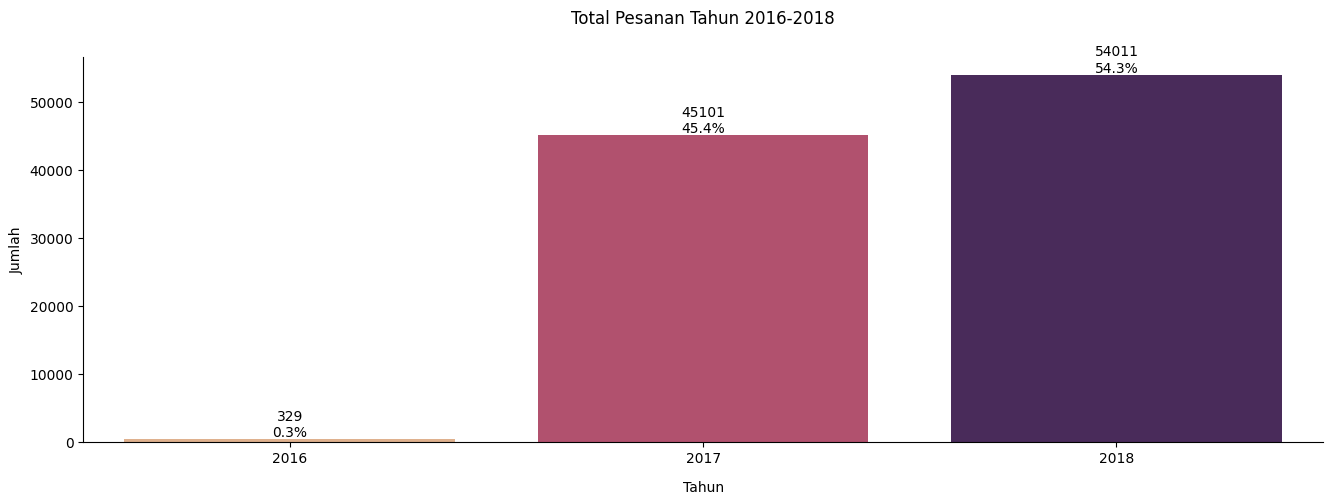

In [ ]:
# Bar plot - plot jumlah transaksi per tahun

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot()

countplot_format(orders,
                 ax=ax,
                 x='order_purchase_year',
                 title='Total Pesanan Tahun 2016-2018',
                 xlabel='Tahun',
                 ylabel='Jumlah',
                 hue='order_purchase_year')

Sekarang kita coba visualisasikan jumlah transaksi per bulan dari 2016 hingga 2018.

Dari grafik di bawah, kita melihat bahwa jumlah transaksi tahun 2016 sangat sedikit. Hal ini mungkin karena disebabkan oleh ketidaklengkapan data pada saat akuisisi dataset.


Pada tahun 2017, jumlah transaksi mengalami peningkatan dari awal hingga akhir tahun. Kemudian tahun 2016 jumlah transaksi cenderung mengalami sedikit penurunan.

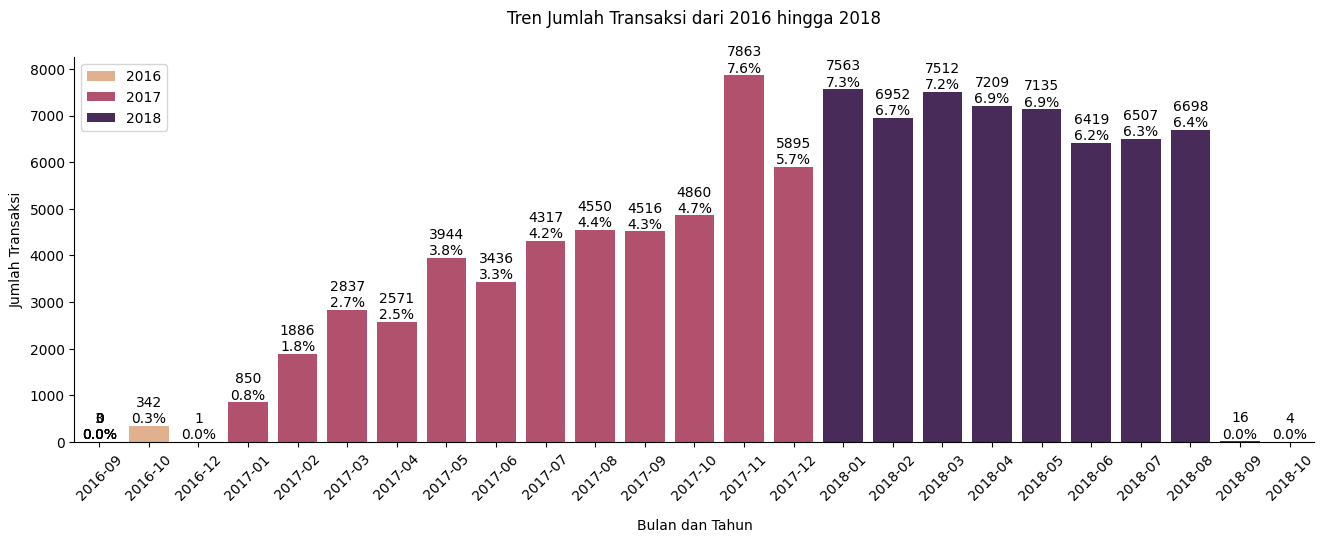

In [ ]:
# Gabungkan data orders dan order_payments berdasarkan order_id
orders_payments_merge = pd.merge(orders, order_payments, on='order_id', how='inner')
monthly_transactions = orders_payments_merge.groupby('order_purchase_year_month')['order_id'].count().reset_index()

# Bar plot - plot jumlah transaksi per bulan per tahun

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot()

countplot_format(orders_payments_merge,
                 x='order_purchase_year_month',
                 ax=ax,
                 title='Tren Jumlah Transaksi dari 2016 hingga 2018',
                 xlabel='Bulan dan Tahun',
                 ylabel='Jumlah Transaksi',
                 rotate_label=True,
                 padding_label=-0.2,
                 order=sorted(orders_payments_merge['order_purchase_year_month'].unique()),
                 hue='order_purchase_year',
                 legend=True)

### 2. Pada hari apa dalam seminggu puncak aktivitas pelanggan melakukan pembelian?

Berikutnya kita visualisasikan kebiasaan customer melakukan pembelian pada hari dan waktu tertentu.

Pada grafik di bawah, dapat dilihat bahwa customer cenderung melakukan pembelian pada hari kerja (*weekdays*), dengan jumlah pembelian terbanyak pada hari Senin.

<ipython-input-2-18708ac906c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_label)


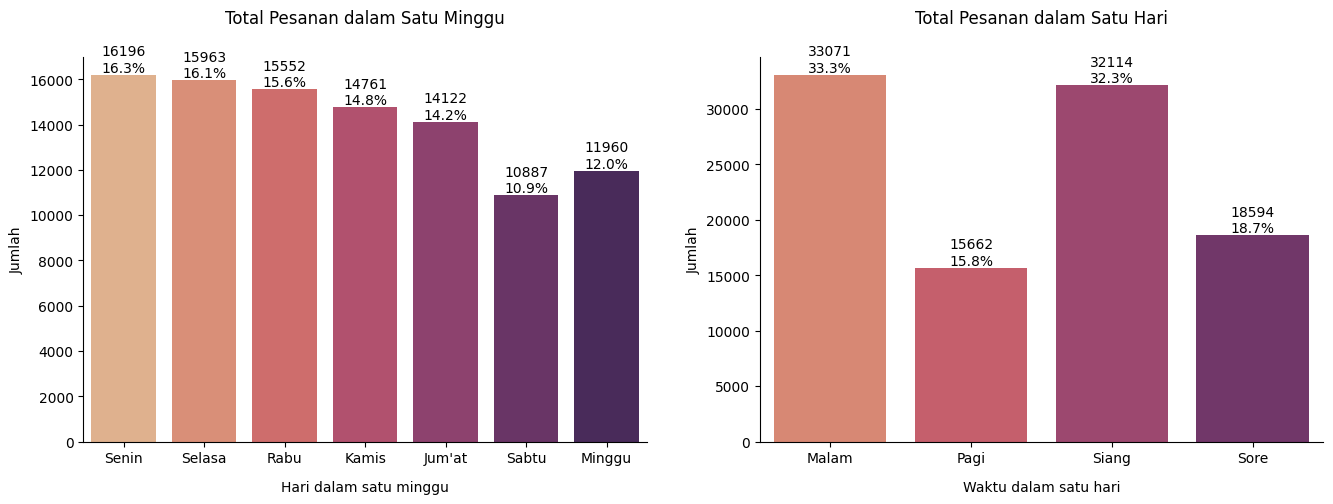

In [ ]:
fig = plt.figure(figsize=(16, 5))

gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Barchart - Total Pesanan dalam Satu Minggu

weekday_label = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jum\'at', 'Sabtu', 'Minggu']

countplot_format(orders,
                 x='order_purchase_dayofweek',
                 ax=ax1,
                 title='Total Pesanan dalam Satu Minggu',
                 xlabel='Hari dalam satu minggu',
                 ylabel='Jumlah',
                 custom_label=weekday_label,
                 hue='order_purchase_dayofweek')

# Barchart - Total Pesanan dalam Satu Hari

countplot_format(orders,
                 x='order_purchase_time_day',
                 ax=ax2,
                 title='Total Pesanan dalam Satu Hari',
                 xlabel='Waktu dalam satu hari',
                 ylabel='Jumlah',
                 hue='order_purchase_time_day')



```
# This is formatted as code
```

### 3. Pada rentang waktu apa pelanggan biasanya melakukan pembelian? (Pagi, Siang, Sore, atau Malam)

Pada grafik yang sama, kita dapat melihat kebiasaan customer melakukan pembelian pada waktu tertentu.

Customer paling banyak melakukan pembelian pada malam dan siang hari.

### 4. Kota mana saja yang memiliki aktivitas pembelian tertinggi?

Berikutnya kita visualisasikan distribusi pelanggan di seluruh wilayah Brazil.

Grafik di bawah menggambarkan 20 kota dengan jumlah pembelian terbanyak. Distribusi customer terbesar berada di kota Sao Paulo, diikuti dengan Rio de Janeiro.

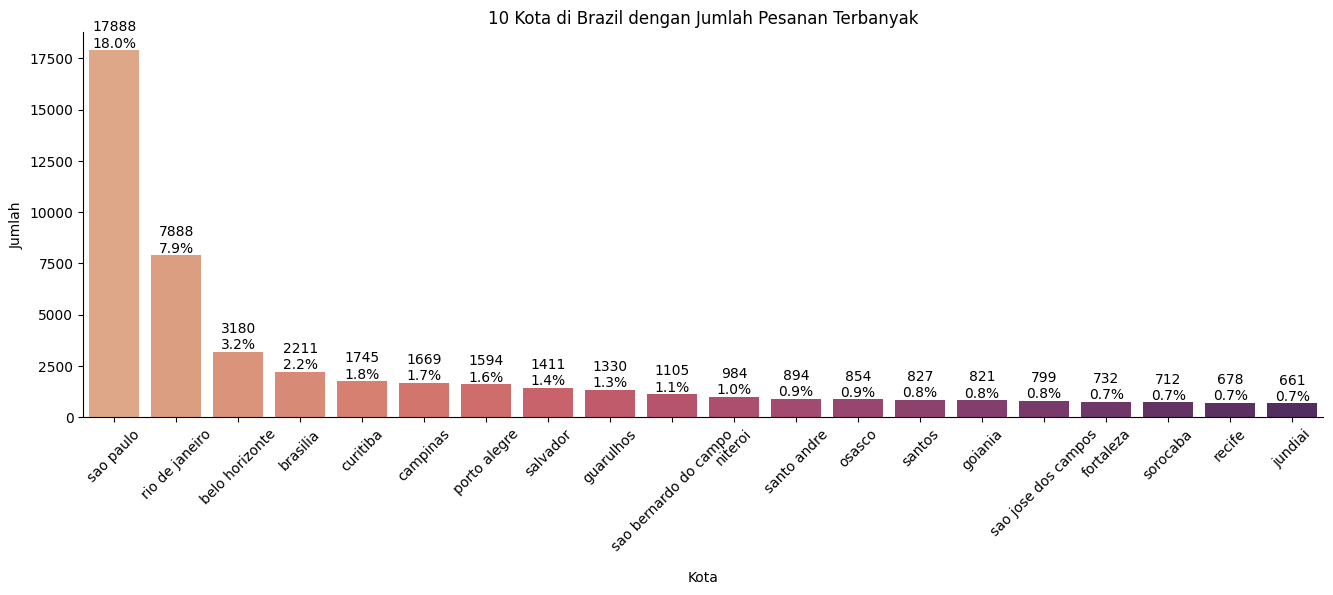

In [ ]:
# Grup berdasarkan kota (top 20)

geo_cities_group = orders_items.groupby(by='geolocation_city', as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
geo_cities_group = geo_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
geo_cities_group = geo_cities_group.iloc[:20, :]

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot()

sns.barplot(x='geolocation_city', y='order_id', data=geo_cities_group, ax=ax, hue='geolocation_city', palette='flare', legend=False)

ax.set_title('10 Kota di Brazil dengan Jumlah Pesanan Terbanyak')
ax.set_xlabel('Kota')
ax.set_ylabel('Jumlah')
ax.xaxis.set_label_coords(0.5, -0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / len(orders)), (x.mean(), y), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

### 5. Bagaimana persebaran geografis aktivitas pembelian di seluruh wilayah Brazil?

Kemudian, kita melakukan *geospatial analysis* untuk mengetahui persebaran aktivitas pembelian dengan lebih baik.

Berdasarkan persebaran aktivitas pembelian di bawah, kita dapat melihat bahwa kota dengan pembelian terbanyak, yaitu Sao Paulo dan Rio de Janeiro, berada di pesisir Selatan Brazil.

In [ ]:
# # Zipping locations
lats = list(orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map)

map

## Kesimpulan

**1. Bagaimana perkembangan transaksi e-commerce di Brazil dari tahun 2016 hingga 2018?**

Tahun 2016 memiliki data yang tidak lengkap karena jumlahnya sangat sedikit. Tahun 2017 hingga 2018, jumlah transaksi mengalami peningkatan yang signifikan.



**2. Pada hari apa dalam seminggu puncak aktivitas pelanggan melakukan pembelian?**

Pelanggan biasa melakukan pembelian pada hari kerja, dengan puncaknya pada hari Senin.



**3. Pada rentang waktu apa pelanggan biasanya melakukan pembelian? (Pagi, Siang, Sore, atau Malam)**

Aktivitas pembelian terbanyak berada pada waktu malam hari.



**4. Kota mana saja yang memiliki aktivitas pembelian tertinggi?**

Kota dengan aktivitas pembelian tertinggi adalah Sao Paulo.



**5. Bagaimana persebaran geografis aktivitas pembelian di seluruh wilayah Brazil?**

Wilayah dengan aktivitas pembelian tertinggi berada di pesisi selatan Brazil, yaitu Kota Sao Paulo dan Rio de Janeiro.
